<a href="https://colab.research.google.com/github/arthijayaraman-lab/CREASE-2D/blob/main/CREASE%20Tutorials/Calculate_1D_Scattering_Profiles_from_3D_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Change Runtime Environment to use GPUs in Colab while running.
  - Runtime > Change runtime type > Hardware accelarator - T4 GPU.



In [1]:
#@title Download Requirements
!pip install cupy-cuda12x

In [2]:
#@title Import Required libraries
import os
import numpy as np
import pickle
from scipy.special import erfcinv
from scipy.special import i0, i1
from scipy.interpolate import interp1d
import sys
import pandas as pd
import glob
import plotly.express as px
import matplotlib.pyplot as plt
import math
import cupy as cp
from time import time
from time import perf_counter

--2024-12-19 05:04:53--  https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20793826 (20M) [text/plain]
Saving to: ‘/content/sample_scatterers.dump’

/content/sample_sca 100%[===================>]  19.83M  --.-KB/s    in 0.1s    

2024-12-19 05:04:53 (166 MB/s) - ‘/content/sample_scatterers.dump’ saved [20793826/20793826]

Processing file: /content/sample_scatterers.dump
Elapsed time: 0.6054668900000024 seconds
Finished processing /content/sample_scatterers.dump. Output saved to /content/output/sample_1D_profile.dump.


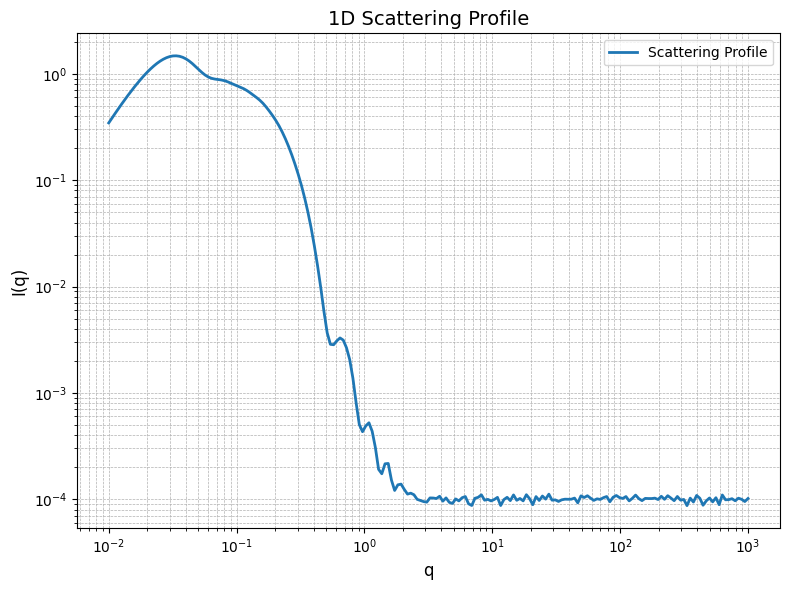

In [3]:
#@title Calculate 1D scattering profile from 3D structure

def fibonacci_sphere(samples=1000, direction=[0, 1, 0]):
    """
    Generate points on a sphere's surface using a Fibonacci spiral algorithm.
    This provides a uniform distribution of directions.
    """
    phi = cp.pi * (3. - cp.sqrt(5.))  # golden angle in radians
    if samples == 1:
        point = cp.array([direction])
        return point / cp.linalg.norm(point, axis=1)

    indices = cp.arange(samples)
    y = 1 - (indices / (samples - 1)) * 2
    radius = cp.sqrt(1 - y * y)
    theta = phi * indices
    x = cp.cos(theta) * radius
    z = cp.sin(theta) * radius
    points = cp.column_stack((x, y, z))
    return points

def single_loop_minus_box(qrange, len_box, box_shift, rs, fis, apply_center_correction=True, direction=[0, 1, 0], total_points=300):
    """
    Compute 1D scattering profile from 3D structure.
    """
    points = cp.asarray(rs[0])  # shape (N, 3)
    v_array = cp.asarray(fibonacci_sphere(total_points, direction).T)  # shape (3, total_points)
    q_range_cp = cp.asarray(qrange)
    if apply_center_correction:
        points = points - cp.asarray(box_shift)

    num_points = points.shape[0]
    num_q = q_range_cp.size
    num_dirs = v_array.shape[1]

    ret = cp.zeros((num_q, num_dirs), dtype=cp.float32)

    start_time = perf_counter()
    batch_size = 10000
    num_batches = (num_points + batch_size - 1) // batch_size
    sum_exp = cp.zeros((num_dirs,), dtype=cp.complex64)

    # Main loop over q
    for qi in range(num_q):
        q = q_range_cp[qi]
        q_vecs = q * v_array  # shape (3, num_dirs)

        sum_exp[:] = 0+0j

        for batch in range(num_batches):
            start = batch * batch_size
            end = min((batch + 1) * batch_size, num_points)
            r_batch = points[start:end]  # shape (batch_size, 3)
            rvqs = cp.matmul(r_batch, q_vecs)  # shape (batch_size, num_dirs)
            sum_exp += cp.exp(-1j * rvqs).sum(axis=0)

        # Box form factor
        qx = q_vecs[0]
        qy = q_vecs[1]
        qz = q_vecs[2]
        # Using np.sinc:
        box_ff = cp.sinc(qx * len_box[0] / (2 * cp.pi)) * \
                 cp.sinc(qy * len_box[1] / (2 * cp.pi)) * \
                 cp.sinc(qz * len_box[2] / (2 * cp.pi))

        sum_exp = sum_exp / num_points - box_ff
        intensity = cp.real(sum_exp * cp.conj(sum_exp))
        ret[qi, :] = intensity

    omega = ret.mean(axis=1)
    end_time = perf_counter()
    print("Elapsed time:", end_time - start_time, "seconds")
    return omega

if __name__ == '__main__':
    # User-defined parameters
    input_file = '/content/sample_scatterers.dump'
    print(f"Downloading input file...")
    !wget -O {input_file} https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
    output_dir = '/content/output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Processing file: {input_file}")
    number_of_atoms = 10000
    atoms_data = []

    with open(input_file, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if "ITEM: ATOMS" in line:
                headers = line.split()[2:]
                # Read the next `number_of_atoms` lines as atom data
                for j in range(number_of_atoms):
                    atom_data = list(map(float, lines[i + j + 1].strip().split()))
                    atoms_data.append(atom_data)
                i += number_of_atoms + 1
            else:
                i += 1

    columns = ['id', 'mol', 'type', 'x', 'y', 'z']
    df = pd.DataFrame(atoms_data, columns=columns)
    pts = np.column_stack((df['x'].values, df['y'].values, df['z'].values))

    # Box dimensions and shift
    boxdim = pd.read_csv(input_file, sep='\s+', header=None, skiprows=5, nrows=3)
    boxdim = cp.array(boxdim.values)
    len_box = boxdim[:, 1] - boxdim[:, 0]
    box_shift = len_box / 2.0

    # q_range
    q_range = cp.logspace(-2, 3, 200)

    # Compute scattering profile
    omega = single_loop_minus_box(q_range, len_box, box_shift, [pts], [1], apply_center_correction=True)

    # Save results
    base_file_name = os.path.basename(input_file)
    output_file_name = base_file_name.replace('_scatterers', '_1D_profile')
    output_file_path = os.path.join(output_dir, output_file_name)

    with open(output_file_path, 'w') as output_file:
        for i in range(len(q_range)):
            output_file.write(f"{q_range[i]} {omega[i]}\n")

    print(f"Finished processing {input_file}. Output saved to {output_file_path}.")

output_file_path = '/content/output/sample_1D_profile.dump'
data = cp.loadtxt(output_file_path)
q_values = data[:, 0]
omega_values = data[:, 1]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(q_values.get(), omega_values.get(), label="Scattering Profile", linewidth=2)
plt.xscale('log')  # Log scale for q-axis
plt.yscale('log')  # Log scale for intensity
plt.xlabel('q', fontsize=12)
plt.ylabel('I(q)', fontsize=12)
plt.title('1D Scattering Profile', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#@title Calculate 2D scattering profile from 3D structure
structure_file = 'sample_scatterers.dump'
print(f"Downloading input file...")
!wget -O {structure_file} https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
#@title Compute 2D Scattering profile for generated structure
# Load data
col_types = {'atoms': 'float32', 'id': 'float32', 'type': 'float32', 'x': 'float32', 'y': 'float32', 'z' : 'float32'}
data = pd.read_csv(structure_file,sep='\s+', skiprows=9, header=None, usecols=[0, 1, 2, 3, 4, 5], dtype=col_types)
boxdim = pd.read_csv(structure_file, sep='\s+', dtype=col_types, header=None, skiprows=5, nrows=3)
data = cp.array(data.values)
boxdim = cp.array(boxdim.values)

# Constants
ntheta, qmin_exp, qmax_exp, nq = 91, -2, 3, 501

# Function to process each chunk
def process_chunk(chunk_id, subXYZ, dir1value, dir2value, qmagvalue, boxformfactor_sphere):
    start_time = time()
    currentchunksize = subXYZ.shape[0]
    qposxy = (qmagvalue @ cp.ones((1, currentchunksize))) * ((dir1value @ subXYZ[:, 0].reshape(1, -1)) + (dir2value @ subXYZ[:, 1].reshape(1, -1)))
    qposyz = (qmagvalue @ cp.ones((1, currentchunksize))) * ((dir1value @ subXYZ[:, 1].reshape(1, -1)) + (dir2value @ subXYZ[:, 2].reshape(1, -1)))
    qposxz = (qmagvalue @ cp.ones((1, currentchunksize))) * ((dir1value @ subXYZ[:, 0].reshape(1, -1)) + (dir2value @ subXYZ[:, 2].reshape(1, -1)))

    resultxy = cp.sum(cp.exp(-1j * qposxy) - boxformfactor_sphere * cp.ones((1, currentchunksize), dtype=cp.float32), axis=1)
    resultyz = cp.sum(cp.exp(-1j * qposyz) - boxformfactor_sphere * cp.ones((1, currentchunksize), dtype=cp.float32), axis=1)
    resultxz = cp.sum(cp.exp(-1j * qposxz) - boxformfactor_sphere * cp.ones((1, currentchunksize), dtype=cp.float32), axis=1)

    elapsed_time = time() - start_time
    print(f"Chunk ID: {chunk_id}, Processed in {elapsed_time:.2f} seconds.")
    return resultxy, resultyz, resultxz

# Main calculation function with batch processing
def gpu_calculations_parallel(data_cp, boxdim_cp):
    # Pre-calculation setup (boxlen, boxrad, qgrid, thetagrid, qmag, dir1grid, dir2grid, etc.)
    boxlen = cp.mean(boxdim_cp[:, 1] - boxdim_cp[:, 0])
    boxrad = boxlen / 2

    q_values = cp.logspace(qmin_exp, qmax_exp, nq, dtype=cp.float32)
    theta_values = cp.linspace(0, cp.pi / 2, ntheta, dtype=cp.float32)
    qgrid, thetagrid = cp.meshgrid(q_values, theta_values, indexing='ij')


    qmag = cp.stack((qgrid, qgrid), axis=2)
    qmag = cp.transpose(qmag, (2, 0, 1))

    cos_thetagrid = cp.cos(thetagrid)
    sin_thetagrid = cp.sin(thetagrid)

    dir1grid = cp.stack((cos_thetagrid, -cos_thetagrid), axis=2)
    dir2grid = cp.stack((sin_thetagrid, sin_thetagrid), axis=2)

    a = cp.transpose(dir1grid, (2, 0, 1))
    b = cp.transpose(dir2grid, (2, 0, 1))

    dir1value = cp.concatenate((
        a[0].T.reshape(-1, 1),
        a[1].T.reshape(-1, 1)
    ), axis=0)

    dir2value = cp.concatenate((
        b[0].T.reshape(-1, 1),
        b[1].T.reshape(-1, 1)
    ), axis=0)

    qmagvalue = cp.concatenate((
        qmag[0].T.reshape(-1, 1),
        qmag[1].T.reshape(-1, 1)
    ), axis=0)

    boxformfactor_sphere = 3 * (cp.sin(qmagvalue * boxrad) - (qmagvalue * boxrad) * cp.cos(qmagvalue * boxrad)) / (qmagvalue * boxrad) ** 3


    # Prepare XYZ data
    XYZ = cp.column_stack((data_cp[:, 3], data_cp[:, 4], data_cp[:, 5]))
    XYZ = cp.mod(XYZ + boxrad, boxlen) - boxrad
    datamap = cp.sum(XYZ ** 2, axis=1) < boxrad ** 2
    XYZ = XYZ[datamap, :]
    Numbeads = XYZ.shape[0]

    # Set batch size and calculate number of batches
    batch_size = 1000  # Adjust based on your GPU memory
    num_batches = math.ceil(Numbeads / batch_size)
    # Initialize results
    Ampxy = Ampyz = Ampxz = 0

    # Process each batch
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, Numbeads)
        subXYZ = XYZ[start_idx:end_idx]

        resultxy, resultyz, resultxz = process_chunk(batch, subXYZ, dir1value, dir2value, qmagvalue, boxformfactor_sphere)
        Ampxy += resultxy
        Ampyz += resultyz
        Ampxz += resultxz

    return Ampxy, Ampyz, Ampxz

# Run the GPU calculations with batch processing
Ampxy, Ampyz, Ampxz = gpu_calculations_parallel(data, boxdim)

# Post-calculation processing (reshape and concatenate data)
resultqxqy = cp.log10(cp.abs(Ampxy * cp.conj(Ampxy)))
resultqyqz = cp.log10(cp.abs(Ampyz * cp.conj(Ampyz)))
resultqxqz = cp.log10(cp.abs(Ampxz * cp.conj(Ampxz)))
resultqxqy = resultqxqy.reshape(2, 91, 501)
resultqxqy1 = cp.transpose(resultqxqy[0])
resultqxqy2 = cp.transpose(resultqxqy[1])
resultqyqz = resultqyqz.reshape(2, 91, 501)
resultqyqz1 = cp.transpose(resultqyqz[0])
resultqyqz2 = cp.transpose(resultqyqz[1])
resultqxqz = resultqxqz.reshape(2, 91, 501)
resultqxqz1 = cp.transpose(resultqxqz[0])
resultqxqz2 = cp.transpose(resultqxqz[1])

# Concatenate and flip
dataxy = cp.concatenate([resultqxqy1[:, :-1], cp.fliplr(resultqxqy2[:, :])], axis=1)
datayz = cp.concatenate([resultqyqz1[:, :-1], cp.fliplr(resultqyqz2[:, :])], axis=1)
dataxz = cp.concatenate([resultqxqz1[:, :-1], cp.fliplr(resultqxqz2[:, :])], axis=1)


# Save results
pd.DataFrame(cp.asnumpy(dataxy)).to_csv('samplestructure_dataxy.txt', header=False, index=False)
pd.DataFrame(cp.asnumpy(datayz)).to_csv('samplestructure_datayz.txt', header=False, index=False)
pd.DataFrame(cp.asnumpy(dataxz)).to_csv('samplestructure_dataxz.txt', header=False, index=False)
print("Data saved successfully.")

--2024-12-19 04:56:34--  https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20793826 (20M) [text/plain]
Saving to: ‘sample_scatterers.dump’

sample_scatterers.d 100%[===================>]  19.83M  --.-KB/s    in 0.07s   

2024-12-19 04:56:36 (271 MB/s) - ‘sample_scatterers.dump’ saved [20793826/20793826]

qmag shape: (2, 501, 91)
Chunk ID: 0, Processed in 1.73 seconds.
Chunk ID: 1, Processed in 0.00 seconds.
Chunk ID: 2, Processed in 0.00 seconds.
Chunk ID: 3, Processed in 0.00 seconds.
Chunk ID: 4, Processed in 0.00 seconds.
Chunk ID: 5, Processed in 0.00 seconds.
Chunk ID: 6, Processed in 0.00 seconds.
Chunk ID: 7, Processed in 0.00 seconds.
Chunk ID:

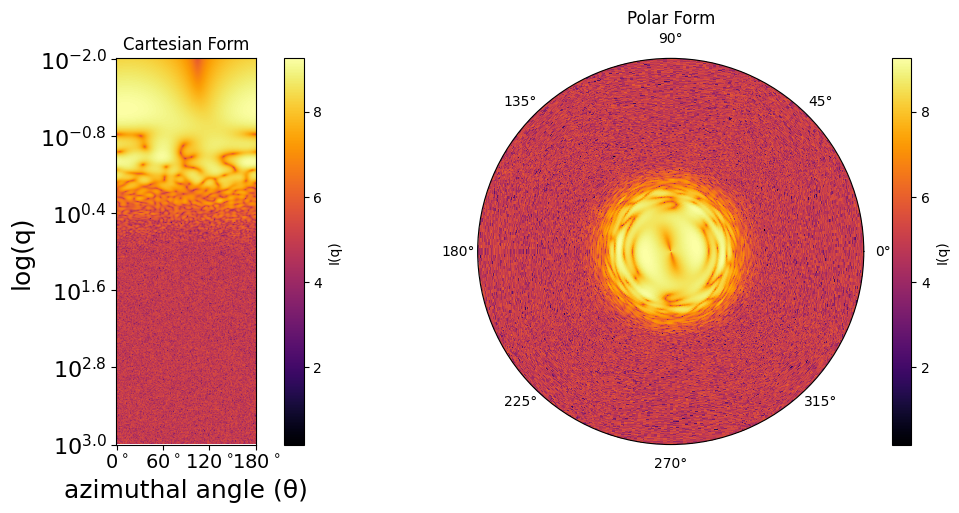

In [ ]:
#@title Plot the 2D scattering profile in cartesian and polar form
dataxy_file = '/content/samplestructure_dataxy.txt'
dataxy = np.loadtxt(dataxy_file, delimiter=',')
dataxy_flipped = dataxy[:, ::-1]
dataxy_full = np.hstack((dataxy_flipped, dataxy_flipped))

theta_deg_full = np.linspace(360, 0, dataxy_full.shape[1])
theta_full = np.radians(theta_deg_full)
q = np.arange(dataxy_full.shape[0])
T, Q = np.meshgrid(theta_full, q)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
im_cart = ax1.imshow(dataxy, cmap='inferno')
fig.colorbar(im_cart, ax=ax1, label='I(q)')
ax1.set_title('Cartesian Form')
ax1.set_xlabel("azimuthal angle (θ)", fontsize=18)
ax1.set_ylabel("log(q)", fontsize=18)
x_positions = [0, 60, 120, 181]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0, 100, 200, 300, 400, 501]
y_ticks = ["$10^{-2.0}$", "$10^{-0.8}$", "$10^{0.4}$", "$10^{1.6}$", "$10^{2.8}$", "$10^{3.0}$"]
ax1.set_xticks(x_positions)
ax1.set_xticklabels(x_ticks, fontsize=14)
ax1.set_yticks(y_positions)
ax1.set_yticklabels(y_ticks, fontsize=16)
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
im_polar = ax2.pcolormesh(T, Q, dataxy_full,cmap='inferno')
ax2.set_theta_zero_location("E")
ax2.set_theta_direction(1)
ax2.set_title('Polar Form')
ax2.grid(False)
ax2.set_rticks([])
fig.colorbar(im_polar, ax=ax2, label='I(q)')
plt.tight_layout()
plt.show()